In [21]:
from transformers import AutoProcessor, LlavaForConditionalGeneration
import torch
import torch.nn.functional as F
from torchinfo import summary
from PIL import Image

import matplotlib.pyplot as plt

In [2]:
MODEL_ID = "llava-hf/llava-1.5-7b-hf"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model = LlavaForConditionalGeneration.from_pretrained(MODEL_ID, torch_dtype=torch.float16).to(device)
processor = AutoProcessor.from_pretrained(MODEL_ID)

`torch_dtype` is deprecated! Use `dtype` instead!
Fetching 2 files: 100%|██████████| 2/2 [00:00<00:00,  6.55it/s]
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [3]:
print(model)
summary(model)

LlavaForConditionalGeneration(
  (model): LlavaModel(
    (vision_tower): CLIPVisionModel(
      (vision_model): CLIPVisionTransformer(
        (embeddings): CLIPVisionEmbeddings(
          (patch_embedding): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14), bias=False)
          (position_embedding): Embedding(577, 1024)
        )
        (pre_layrnorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (encoder): CLIPEncoder(
          (layers): ModuleList(
            (0-23): 24 x CLIPEncoderLayer(
              (self_attn): CLIPAttention(
                (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
                (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
                (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
                (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
              )
              (layer_norm1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
       

Layer (type:depth-idx)                                                 Param #
LlavaForConditionalGeneration                                          --
├─LlavaModel: 1-1                                                      --
│    └─CLIPVisionModel: 2-1                                            --
│    │    └─CLIPVisionTransformer: 3-1                                 303,507,456
│    └─LlavaMultiModalProjector: 2-2                                   --
│    │    └─Linear: 3-2                                                4,198,400
│    │    └─GELUActivation: 3-3                                        --
│    │    └─Linear: 3-4                                                16,781,312
│    └─LlamaModel: 2-3                                                 --
│    │    └─Embedding: 3-5                                             131,334,144
│    │    └─ModuleList: 3-6                                            6,476,267,520
│    │    └─LlamaRMSNorm: 3-7                                  

In [6]:
IMAGE_PATH = "/masuda/experiments/ichikawa/data/000000000872.jpg" 



In [10]:
summary(model.model.vision_tower)

Layer (type:depth-idx)                                       Param #
CLIPVisionModel                                              --
├─CLIPVisionTransformer: 1-1                                 --
│    └─CLIPVisionEmbeddings: 2-1                             1,024
│    │    └─Conv2d: 3-1                                      602,112
│    │    └─Embedding: 3-2                                   590,848
│    └─LayerNorm: 2-2                                        2,048
│    └─CLIPEncoder: 2-3                                      --
│    │    └─ModuleList: 3-3                                  302,309,376
│    └─LayerNorm: 2-4                                        2,048
Total params: 303,507,456
Trainable params: 303,507,456
Non-trainable params: 0

In [13]:
image = Image.open(IMAGE_PATH)


inputs = processor(images=image,  text="", return_tensors="pt")
pixel_values = inputs["pixel_values"].to(device=device, dtype=model.dtype)  # float16に合わせる

# ----------------------------
# Vision Tower → Projector の通過
# ----------------------------
with torch.no_grad():
    # CLIPVisionModel の出力（last_hidden_state: [B, seq_len(=577), 1024]）
    vision_out = model.model.vision_tower(pixel_values=pixel_values)
    image_features = vision_out.last_hidden_state  # 形状: [B, 577, 1024]

    # LlavaMultiModalProjector で言語側次元(4096)へ写像
    projected = model.model.multi_modal_projector(image_features)  # 形状: [B, 577, 4096]

# ----------------------------
# 結果の確認
# ----------------------------
print("vision_out.last_hidden_state shape:", image_features.shape)  # => [1, 577, 1024]
print("projected (after LlavaMultiModalProjector) shape:", projected.shape)  # => [1, 577, 4096]

# 先頭トークン（CLS相当）の数値を少しだけ表示
b, t = 0, 0  
# b = 0 → バッチの中で 最初の画像を選択
# t = 0 → シーケンスの中で 最初のトークン（[CLS] 相当のグローバルトークン）を選択

print("projected : ", projected[b, t].float().cpu().tolist())

vision_out.last_hidden_state shape: torch.Size([1, 577, 1024])
projected (after LlavaMultiModalProjector) shape: torch.Size([1, 577, 4096])
projected :  [0.09503173828125, 0.258056640625, 0.264892578125, 0.479248046875, -0.412109375, -0.09820556640625, 0.08941650390625, 0.296630859375, 0.85302734375, 0.314453125, -0.49951171875, -0.1156005859375, -0.098876953125, -0.1624755859375, -0.0250701904296875, 0.302734375, 0.005535125732421875, -0.216064453125, 0.274169921875, 0.2049560546875, -0.061676025390625, 0.225341796875, 0.433837890625, -0.2425537109375, 0.845703125, 0.053619384765625, -0.01053619384765625, 0.6474609375, 0.06402587890625, 0.8505859375, -0.22314453125, 0.64501953125, -0.1319580078125, 0.204833984375, 0.6005859375, -0.038238525390625, -0.47412109375, 0.29052734375, 0.03778076171875, 0.640625, -0.2098388671875, -0.2396240234375, 0.11322021484375, -0.199462890625, 0.32373046875, 0.58203125, -0.12646484375, -0.06060791015625, -0.2666015625, -0.01195526123046875, -0.322265625

In [ ]:
b, t = 0, 0  # 最初の画像・最初のトークンを選択
image_vec = projected[b, t]   # shape: [4096]

# テキスト埋め込み行列を取得 
# shape: [vocab_size, hidden_dim] = [32064, 4096]
text_embeds = model.model.language_model.embed_tokens.weight

# コサイン類似度を計算
# 内積を計算して正規化
sims = F.cosine_similarity(image_vec.unsqueeze(0), text_embeds, dim=1)  # shape: [vocab_size]

# 上位k件を取得
k = 50
topk = torch.topk(sims, k)

# 結果を表示
print("Top-{} most similar tokens:".format(k))
for score, idx in zip(topk.values.tolist(), topk.indices.tolist()):
    token_str = processor.tokenizer.decode([idx])
    print(f"  {idx:5d} | {score:.4f} | {repr(token_str)}")


Top-50 most similar tokens:
  11581 | 0.0748 | 'gain'
  18212 | 0.0681 | 'стру'
   4418 | 0.0673 | 'fail'
  11933 | 0.0613 | 'ген'
  29955 | 0.0611 | '7'
    649 | 0.0609 | 'put'
   1467 | 0.0606 | 'rol'
  22728 | 0.0605 | 'scratch'
  30898 | 0.0603 | '度'
    729 | 0.0599 | 'ror'
  17572 | 0.0598 | 'wort'
   6929 | 0.0594 | 'jection'
   2833 | 0.0587 | 'seem'
   3851 | 0.0581 | 'ugin'
  27591 | 0.0579 | 'stdout'
   7544 | 0.0576 | 'ROR'
   8812 | 0.0570 | 'suffer'
  23377 | 0.0570 | 'idor'
  25393 | 0.0569 | 'stdout'
   8275 | 0.0568 | 'infin'
   5444 | 0.0567 | 'fa'
  15764 | 0.0567 | 'flags'
  22355 | 0.0565 | 'verlor'
    653 | 0.0564 | 'ary'
  30047 | 0.0562 | 'ř'
  22134 | 0.0562 | 'tie'
  20342 | 0.0562 | 'ardon'
   2583 | 0.0562 | 'лю'
  14119 | 0.0560 | 'oire'
  12313 | 0.0560 | 'bad'
  30787 | 0.0559 | 'よ'
    641 | 0.0559 | 'ри'
  23942 | 0.0559 | 'urls'
  16892 | 0.0558 | 'tick'
  19861 | 0.0557 | 'conscious'
  11723 | 0.0556 | 'vr'
  26968 | 0.0555 | 'roe'
  11755 | 0.0554 

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


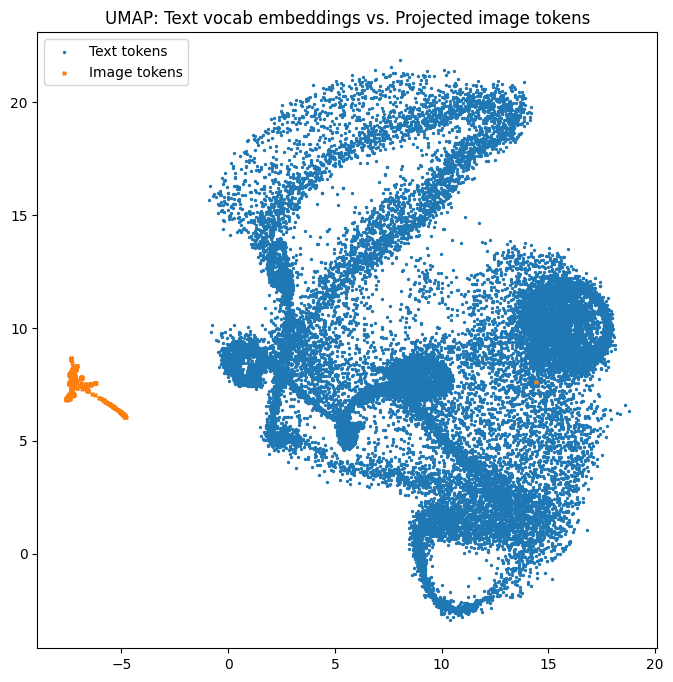

In [22]:

# 埋め込み取得
img_tokens = projected[0].float().cpu()  # [577, 4096]
text_embeds = model.model.language_model.embed_tokens.weight.detach().float().cpu()  # [vocab, 4096]

# 次元削減 (UMAP) 
from umap import UMAP
reducer = UMAP(n_components=2, random_state=42)

X = torch.cat([text_embeds, img_tokens], dim=0).numpy()
X_2d = reducer.fit_transform(X)

# インデックス分割
M = text_embeds.shape[0]
text_2d = X_2d[:M]
img_2d = X_2d[M:]

# 可視化
plt.figure(figsize=(8, 8))
plt.scatter(text_2d[:, 0], text_2d[:, 1], s=2, label="Text tokens")
plt.scatter(img_2d[:, 0], img_2d[:, 1], s=6, marker="x", label="Image tokens")
plt.legend()
plt.title("UMAP: Text vocab embeddings vs. Projected image tokens")
plt.show()
